# Recurrent Neural Networks

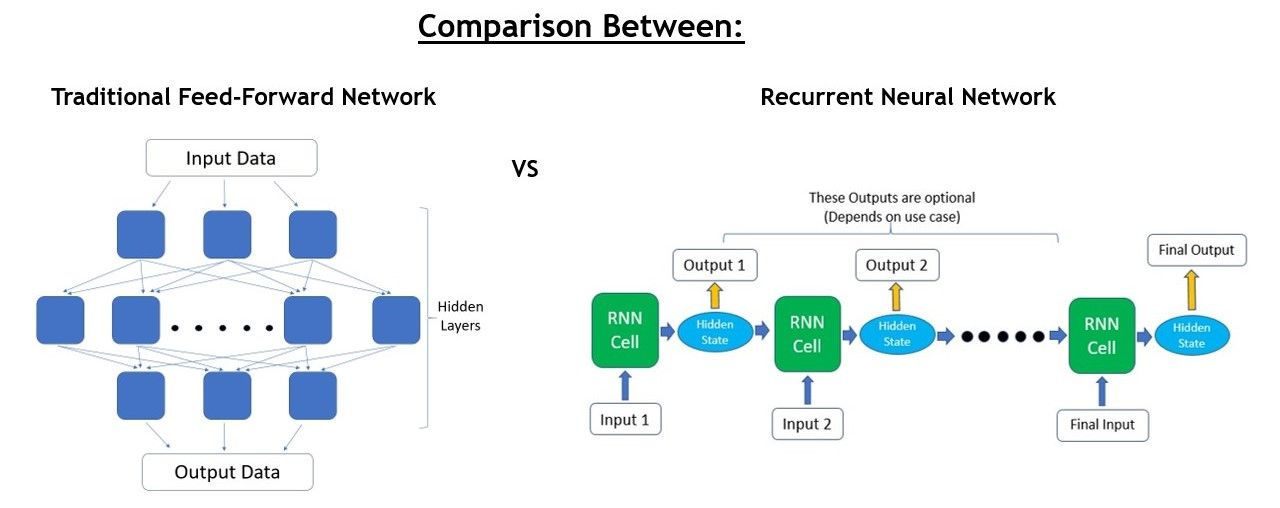

[source](https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)

Till now we have seen MLP and CNN networks, where CNNs where designed to process image data. Recurrent Neural Networks (RNNs) where designed to process sequential data

### Examples of sequential data problems

- Stock market predictions (Time series analysis)
- Natural Language tasks like sentiement analysis, text-generation

## Variations

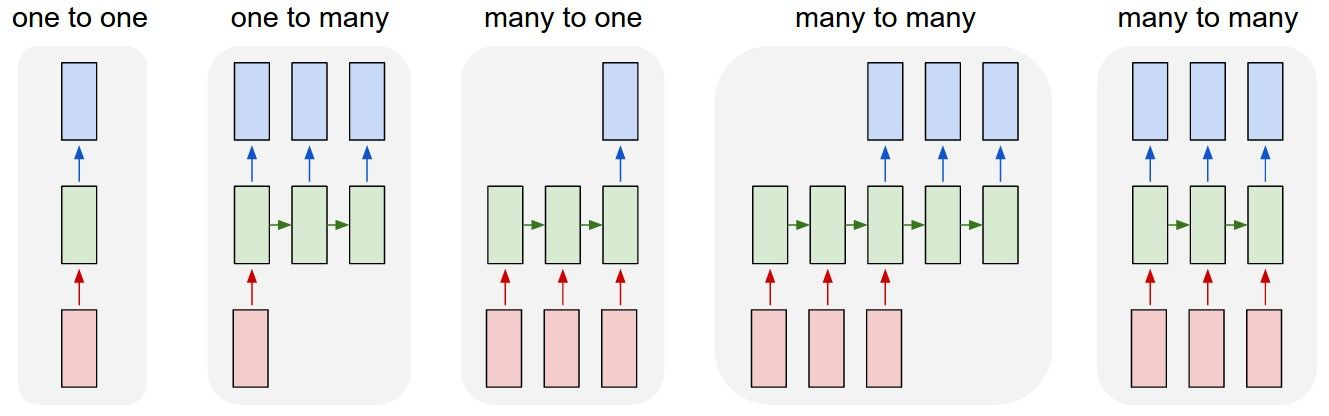

[source](http://karpathy.github.io/?ref=floydhub-blog)

## RNN cell

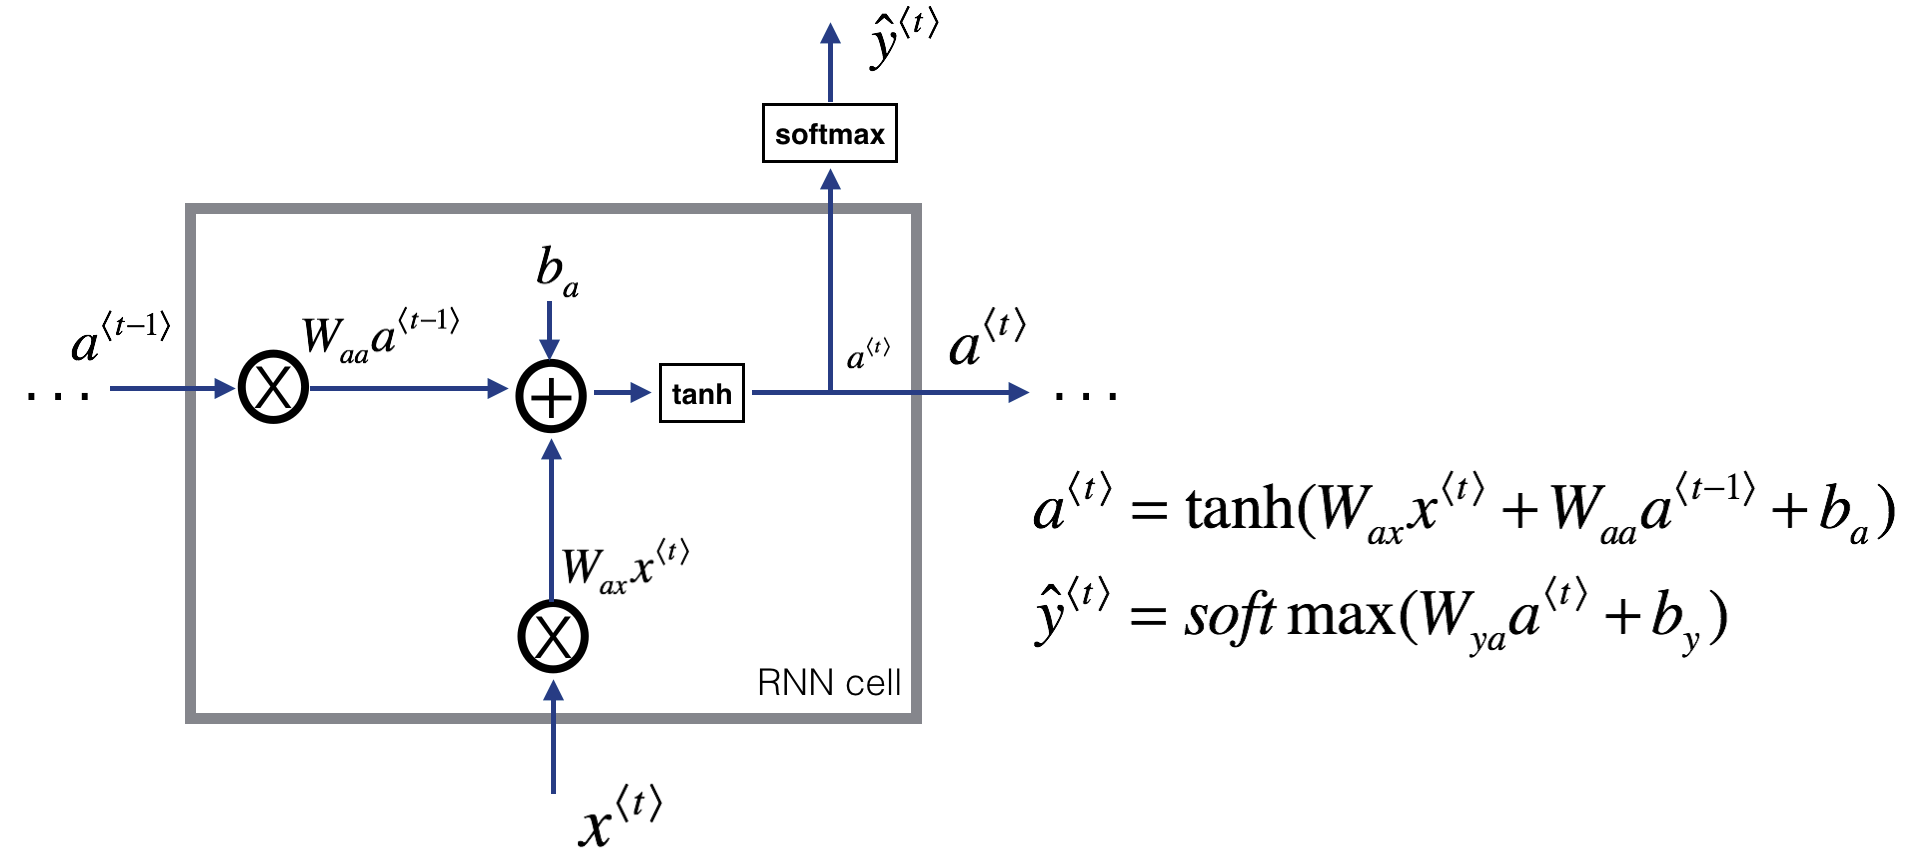

## Question

1. Write a custom RNN cell
2. Create a custom model for sentiment analysis in PyTorch
  - https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
  - You can assume that the sentences are converted to vectors of the corresponding input_dim

In [ ]:
# Answer 1

import torch
from torch import nn

class my_RNN(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.Wax = nn.Linear(input_dim,hidden_dim)
    self.Waa = nn.Linear(hidden_dim,hidden_dim)
    self.Wya = nn.Linear(hidden_dim,output_dim)
    pass
  def forward(self,curr_input,prev_hidden):
    xt = self.Wax(curr_input)
    at = self.Waa(prev_hidden)
    curr_hidden = torch.tanh(xt+at)
    curr_out = self.Wya(curr_hidden)
    # softmax


In [ ]:
# Answer 2
class sentiment_model(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.rnn = nn.RNN(input_dim,hidden_dim,num_layers = 10, dropout=0.2)
    self.fc= nn.Linear(hidden_dim,output_dim)

  def forward(self,x):


# RNN Encoder-Decoder

- Machine translation (Google Translate)

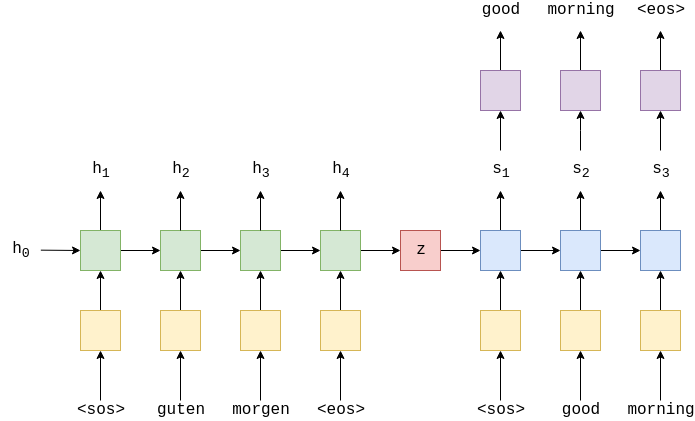

[source](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

In [ ]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
#
# Reload environment
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 846.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you hav

In [ ]:

import time, random, math, string

import numpy as np 
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


### Data processing

In [ ]:
tokenizer = lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).strip().split() 
reverse_tokenizer = lambda x: tokenizer(x)[::-1]

SRC = Field(tokenize=reverse_tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)

train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),
                                                   fields=(SRC, TRG))

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of test examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of test examples: 1000


In [ ]:
print(vars(train_data.examples[0]))

{'src': ['büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes']}


In [ ]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7805
Unique tokens in target (en) vocabulary: 5940


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATHC_SIZE = 128
# We use a BucketIterator instead of the standard Iterator as it create batches in such a way that it minimizes the amount 
# of padding in both the source and target sentences.
train_iter, valid_iter, test_iter = BucketIterator.splits((train_data, valid_data, test_data),
                                                          batch_size=BATHC_SIZE, device=device)

In [ ]:
device

device(type='cuda')

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        # src : [sen_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        
        # embedded : [sen_len, batch_size, emb_dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [sen_len, batch_size, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        # cell = [n_layers * n_direction, batch_size, hid_dim]
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=self.n_layers, dropout=dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        # input = [batch_size]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        input = input.unsqueeze(0)
        # input : [1, ,batch_size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq_len, batch_size, hid_dim * n_dir]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        # seq_len and n_dir will always be 1 in the decoder
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch_size, output_dim]
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            'hidden dimensions of encoder and decoder must be equal.'
        assert encoder.n_layers == decoder.n_layers, \
            'n_layers of encoder and decoder must be equal.'
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = trg[0, :]
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = trg[t] if teacher_force else top1
            
        return outputs

In [ ]:
# First initialize our model.
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(encoder, decoder, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7805, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5940, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5940, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,922,356 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        # trg = [sen_len, batch_size]
        # output = [trg_len, batch_size, output_dim]
        output = model(src, trg)
        output_dim = output.shape[-1]
        
        # transfrom our output : slice off the first column, and flatten the output into 2 dim.
        output = output[1:].view(-1, output_dim) 
        trg = trg[1:].view(-1)
        # trg = [(trg_len-1) * batch_size]
        # output = [(trg_len-1) * batch_size, output_dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        
        for i, batch in enumerate(iterator):
            
            src = batch.src
            trg = batch.trg
            
            output = model(src, trg, 0) # turn off teacher forcing.
            
            # trg = [sen_len, batch_size]
            # output = [sen_len, batch_size, output_dim]
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

In [ ]:
# a function that used to tell us how long an epoch takes.
def epoch_time(start_time, end_time):
    
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time  / 60)
    elapsed_secs = int(elapsed_time -  (elapsed_mins * 60))
    return  elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Seq2SeqModel.pt')
    print(f"Epoch: {epoch+1:02} | Time {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}")
    

Epoch: 01 | Time 0m 39s
	Train Loss: 5.204 | Train PPL: 181.940
	Valid Loss: 5.117 | Valid PPL: 166.800
Epoch: 02 | Time 0m 39s
	Train Loss: 4.639 | Train PPL: 103.478
	Valid Loss: 4.890 | Valid PPL: 132.894
Epoch: 03 | Time 0m 39s
	Train Loss: 4.366 | Train PPL:  78.704
	Valid Loss: 4.794 | Valid PPL: 120.779
Epoch: 04 | Time 0m 39s
	Train Loss: 4.190 | Train PPL:  65.999
	Valid Loss: 4.745 | Valid PPL: 114.958
Epoch: 05 | Time 0m 39s
	Train Loss: 4.035 | Train PPL:  56.541
	Valid Loss: 4.555 | Valid PPL:  95.109
Epoch: 06 | Time 0m 40s
	Train Loss: 3.898 | Train PPL:  49.315
	Valid Loss: 4.470 | Valid PPL:  87.318
Epoch: 07 | Time 0m 39s
	Train Loss: 3.770 | Train PPL:  43.398
	Valid Loss: 4.372 | Valid PPL:  79.230
Epoch: 08 | Time 0m 39s
	Train Loss: 3.632 | Train PPL:  37.781
	Valid Loss: 4.324 | Valid PPL:  75.483
Epoch: 09 | Time 0m 39s
	Train Loss: 3.522 | Train PPL:  33.843
	Valid Loss: 4.276 | Valid PPL:  71.943
Epoch: 10 | Time 0m 39s
	Train Loss: 3.405 | Train PPL:  30.103


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def test():
    best_model = Seq2Seq(encoder, decoder, device).to(device)
    best_model.load_state_dict(torch.load('Seq2SeqModel.pt'))
    
    test_loss = evaluate(model, test_iter, criterion)
    
    print(f"Test Loss : {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}")
    
test()

Test Loss : 4.110 | Test PPL:  60.941


In [ ]:
src_itos = SRC.vocab.itos
trg_itos = TRG.vocab.itos
for i, batch in enumerate(test_iter):
   src = batch.src
   trg = batch.trg
   idx = 0
   src_string = ""
   trg_string = ""
   for i in list(src[:,idx])[::-1]:
     if('>' in src_itos[i] and 'unk' not in src_itos[i]):
       continue
     src_string += src_itos[i]
     src_string += " "
   for i in trg[:,idx]:
     if('>' in trg_itos[i] and 'unk' not in src_itos[i]):
       continue
     trg_string += trg_itos[i]
     trg_string += " "
   print("German sentence :",src_string)
   print("English sentence: ",trg_string)

   break

German sentence : <unk> asiatisches einkaufszentrum mit <unk> und einkäufern 
English sentence:  busy asian mall with paper lanterns and shoppers 


geschäftiges asiatisches einkaufszentrum mit papierlaternen und käufern

# Exploding and vanishing gradients

- Gradients are suspectible to either explore or vanish due to the way backproogation is done; Iteratievely multiplying gradient from previous layers.

- In RNN, this becomes a very serious issue and also one of the main drawbacks of RNNs, as in RNNs we have multiple time steps, the gradient at time step n is depenedent on all time steps from 0 to n-1. This could lead the gradient to vanish (multiplying smaller and smaller values) or explode(multiplying bigger and bigger values)
- Exploding gradient might not lead to the optimum value for the cost function.
- Vanishing gradient might increase the overall training time by many folds and therefore the training might not result in the optimum value for the cost function


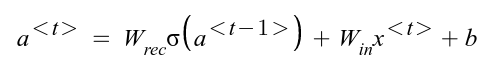

We denote by :

$a_t$ the hidden state of the network at time t

$x_t$ the input 

$ŷ_t$ the output of the network at time t

$C_t$ the error obtained from the output at time t.

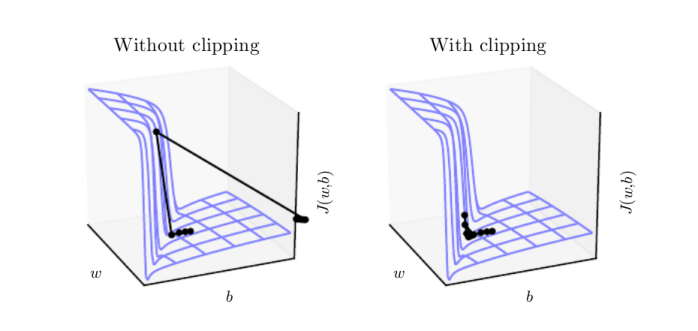

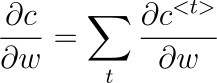

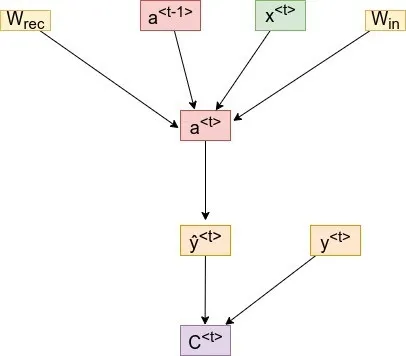

Dependency graph

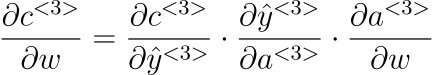

But $a_3$ is not constant! It depends on $a_2$, which in turn depends on $a_1$. 

The whole dependency for a time step t would be as follows $a_t$ --> $a_{t-1}$ --> $a_{t-2}$ ... --> $a_2$ --> $a_1$

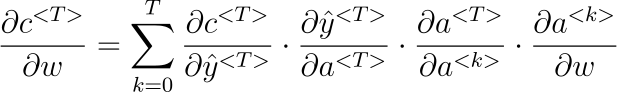

So have we taken care of all dependencies?? Well no!

$da_{3}/da_{1}$ is itself a chain rule. Expanding it to the atomic elements will result in $da_{3}/da_{2}$ * $da_{2}/da_{1}$

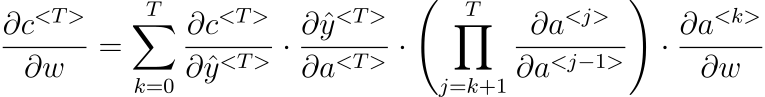

This partiuclar element in the final equation can either vanish or explore and thereby making the whole gradient vanish or explore
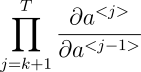

[source](https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)

L2 regularisation and some activation functions like ReLU help us in keeping gradients stable and not vanish or explode. Another method is to use gradient clipping, where we make sure that gradients are within a threshold 

In [ ]:
import time
from tqdm import tqdm
import numpy as np
from sklearn.datasets import make_regression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms



/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.9/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")


ModuleNotFoundError: ignored

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 25)
        self.fc2 = nn.Linear(25, 1)

        self.ordered_layers = [self.fc1,
                               self.fc2]
    def forward(self, x):
        x = F.relu(self.fc1(x))
        outputs = self.fc2(x)
        return outputs

In [ ]:
grad_clipped = []
grad_non_clipped = []

In [ ]:
def train_model(model,
                criterion,
                optimizer,
                num_epochs,
                with_clip=True):
    since = time.time()
    dataset_size = 1000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        time.sleep(0.1)
        model.train()  # Set model to training mode

        running_loss = 0.0
        batch_norm = []

        # Iterate over data.
        for idx,(inputs,label) in enumerate(tqdm(train_loader)):
            inputs = inputs.to(device)
            label = label.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            logits = model(inputs)
            loss = criterion(logits, label)

            # backward
            loss.backward()

            #Gradient Value Clipping
            if with_clip:
                nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

            # calculate gradient norms
            for layer in model.ordered_layers:
                norm_grad = layer.weight.grad.norm()
                batch_norm.append(norm_grad.detach().cpu().numpy())

            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / dataset_size
        print("dataset_size:",dataset_size)
        if(with_clip):
          grad_clipped.append(np.mean(batch_norm))
        else:
          grad_non_clipped.append(np.mean(batch_norm))

        print('Train Loss: {:.4f}'.format(epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
if __name__ == "__main__":
    device = torch.device("cuda")
    

    # prepare data
    X,y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

    X = torch.Tensor(X)
    y = torch.Tensor(y)

    dataset = torch.utils.data.TensorDataset(X,y)
    train_loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=128, shuffle=True)

    model = Net().to(device)
    model.apply(init_weights)
    optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.8)
    criterion = nn.MSELoss()

    norms = train_model(model=model,
                        criterion=criterion,
                        optimizer=optimizer,
                        num_epochs=50,
                        with_clip=True #make it False for without clipping
                        )

<ipython-input-36-3e2b5c514dda>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Epoch 0/50
----------


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 8/8 [00:00<00:00, 331.90it/s]


dataset_size: 1000
Train Loss: 23334.2408

Epoch 1/50
----------


100%|██████████| 8/8 [00:00<00:00, 487.81it/s]


dataset_size: 1000
Train Loss: 23358.1327

Epoch 2/50
----------


100%|██████████| 8/8 [00:00<00:00, 424.39it/s]


dataset_size: 1000
Train Loss: 23318.3849

Epoch 3/50
----------


100%|██████████| 8/8 [00:00<00:00, 393.94it/s]


dataset_size: 1000
Train Loss: 23390.6512

Epoch 4/50
----------


100%|██████████| 8/8 [00:00<00:00, 462.28it/s]


dataset_size: 1000
Train Loss: 23329.7030

Epoch 5/50
----------


100%|██████████| 8/8 [00:00<00:00, 471.54it/s]


dataset_size: 1000
Train Loss: 23322.1524

Epoch 6/50
----------


100%|██████████| 8/8 [00:00<00:00, 464.16it/s]


dataset_size: 1000
Train Loss: 23320.3328

Epoch 7/50
----------


100%|██████████| 8/8 [00:00<00:00, 456.61it/s]


dataset_size: 1000
Train Loss: 23318.5419

Epoch 8/50
----------


100%|██████████| 8/8 [00:00<00:00, 463.67it/s]


dataset_size: 1000
Train Loss: 23318.5301

Epoch 9/50
----------


100%|██████████| 8/8 [00:00<00:00, 444.88it/s]


dataset_size: 1000
Train Loss: 23316.1861

Epoch 10/50
----------


100%|██████████| 8/8 [00:00<00:00, 483.86it/s]


dataset_size: 1000
Train Loss: 23318.5020

Epoch 11/50
----------


100%|██████████| 8/8 [00:00<00:00, 461.45it/s]


dataset_size: 1000
Train Loss: 23316.8052

Epoch 12/50
----------


100%|██████████| 8/8 [00:00<00:00, 447.70it/s]


dataset_size: 1000
Train Loss: 23318.9300

Epoch 13/50
----------


100%|██████████| 8/8 [00:00<00:00, 458.00it/s]


dataset_size: 1000
Train Loss: 23330.3590

Epoch 14/50
----------


100%|██████████| 8/8 [00:00<00:00, 421.44it/s]


dataset_size: 1000
Train Loss: 23317.2292

Epoch 15/50
----------


100%|██████████| 8/8 [00:00<00:00, 465.62it/s]


dataset_size: 1000
Train Loss: 23325.6780

Epoch 16/50
----------


100%|██████████| 8/8 [00:00<00:00, 472.31it/s]


dataset_size: 1000
Train Loss: 23319.2858

Epoch 17/50
----------


100%|██████████| 8/8 [00:00<00:00, 459.57it/s]


dataset_size: 1000
Train Loss: 23321.8357

Epoch 18/50
----------


100%|██████████| 8/8 [00:00<00:00, 447.19it/s]


dataset_size: 1000
Train Loss: 23315.8361

Epoch 19/50
----------


100%|██████████| 8/8 [00:00<00:00, 267.52it/s]


dataset_size: 1000
Train Loss: 23313.7770

Epoch 20/50
----------


100%|██████████| 8/8 [00:00<00:00, 458.46it/s]


dataset_size: 1000
Train Loss: 23314.5311

Epoch 21/50
----------


100%|██████████| 8/8 [00:00<00:00, 471.49it/s]


dataset_size: 1000
Train Loss: 23316.3285

Epoch 22/50
----------


100%|██████████| 8/8 [00:00<00:00, 482.28it/s]


dataset_size: 1000
Train Loss: 23314.5240

Epoch 23/50
----------


100%|██████████| 8/8 [00:00<00:00, 462.65it/s]


dataset_size: 1000
Train Loss: 23315.3480

Epoch 24/50
----------


100%|██████████| 8/8 [00:00<00:00, 468.30it/s]


dataset_size: 1000
Train Loss: 23317.5364

Epoch 25/50
----------


100%|██████████| 8/8 [00:00<00:00, 461.29it/s]


dataset_size: 1000
Train Loss: 23313.2049

Epoch 26/50
----------


100%|██████████| 8/8 [00:00<00:00, 449.29it/s]


dataset_size: 1000
Train Loss: 23316.9015

Epoch 27/50
----------


100%|██████████| 8/8 [00:00<00:00, 471.08it/s]


dataset_size: 1000
Train Loss: 23315.8765

Epoch 28/50
----------


100%|██████████| 8/8 [00:00<00:00, 412.53it/s]


dataset_size: 1000
Train Loss: 23317.2415

Epoch 29/50
----------


100%|██████████| 8/8 [00:00<00:00, 461.06it/s]


dataset_size: 1000
Train Loss: 23316.2158

Epoch 30/50
----------


100%|██████████| 8/8 [00:00<00:00, 460.98it/s]


dataset_size: 1000
Train Loss: 23313.6502

Epoch 31/50
----------


100%|██████████| 8/8 [00:00<00:00, 470.15it/s]


dataset_size: 1000
Train Loss: 23313.3477

Epoch 32/50
----------


100%|██████████| 8/8 [00:00<00:00, 457.13it/s]


dataset_size: 1000
Train Loss: 23314.9063

Epoch 33/50
----------


100%|██████████| 8/8 [00:00<00:00, 442.04it/s]


dataset_size: 1000
Train Loss: 23310.9340

Epoch 34/50
----------


100%|██████████| 8/8 [00:00<00:00, 459.40it/s]


dataset_size: 1000
Train Loss: 23315.3359

Epoch 35/50
----------


100%|██████████| 8/8 [00:00<00:00, 443.54it/s]


dataset_size: 1000
Train Loss: 23313.1862

Epoch 36/50
----------


100%|██████████| 8/8 [00:00<00:00, 449.93it/s]


dataset_size: 1000
Train Loss: 23312.2563

Epoch 37/50
----------


100%|██████████| 8/8 [00:00<00:00, 472.76it/s]


dataset_size: 1000
Train Loss: 23311.9160

Epoch 38/50
----------


100%|██████████| 8/8 [00:00<00:00, 466.69it/s]


dataset_size: 1000
Train Loss: 23312.1623

Epoch 39/50
----------


100%|██████████| 8/8 [00:00<00:00, 455.73it/s]


dataset_size: 1000
Train Loss: 23312.0833

Epoch 40/50
----------


100%|██████████| 8/8 [00:00<00:00, 452.17it/s]


dataset_size: 1000
Train Loss: 23313.4175

Epoch 41/50
----------


100%|██████████| 8/8 [00:00<00:00, 440.07it/s]


dataset_size: 1000
Train Loss: 23311.5354

Epoch 42/50
----------


100%|██████████| 8/8 [00:00<00:00, 460.55it/s]


dataset_size: 1000
Train Loss: 23312.2854

Epoch 43/50
----------


100%|██████████| 8/8 [00:00<00:00, 465.87it/s]


dataset_size: 1000
Train Loss: 23314.4924

Epoch 44/50
----------


100%|██████████| 8/8 [00:00<00:00, 468.21it/s]


dataset_size: 1000
Train Loss: 23313.3248

Epoch 45/50
----------


100%|██████████| 8/8 [00:00<00:00, 471.48it/s]


dataset_size: 1000
Train Loss: 23311.6877

Epoch 46/50
----------


100%|██████████| 8/8 [00:00<00:00, 440.37it/s]


dataset_size: 1000
Train Loss: 23316.7178

Epoch 47/50
----------


100%|██████████| 8/8 [00:00<00:00, 471.39it/s]


dataset_size: 1000
Train Loss: 23315.9323

Epoch 48/50
----------


100%|██████████| 8/8 [00:00<00:00, 456.49it/s]


dataset_size: 1000
Train Loss: 23314.0083

Epoch 49/50
----------


100%|██████████| 8/8 [00:00<00:00, 456.14it/s]

dataset_size: 1000
Train Loss: 23313.5969

Training complete in 0m 6s


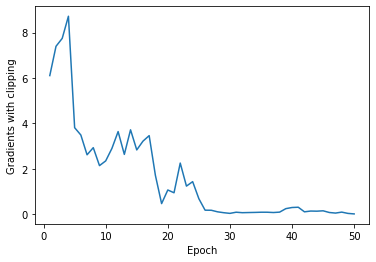

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,51)), grad_clipped)
plt.ylabel('Gradients with clipping')
plt.xlabel('Epoch')

plt.show()

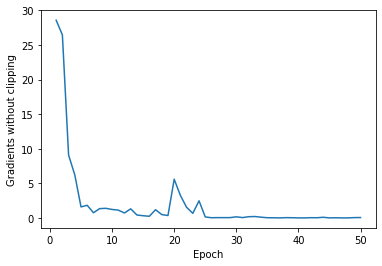

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,51)),grad_non_clipped )
plt.ylabel('Gradients without clipping')
plt.xlabel('Epoch')

plt.show()